In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from Korpora import Korpora
corpus = Korpora.load("korean_petitions")


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : Hyunjoong Kim lovit@github
    Repository : https://github.com/lovit/petitions_archive
    References :

    청와대 국민청원 게시판의 데이터를 월별로 수집한 것입니다.
    청원은 게시판에 글을 올린 뒤, 한달 간 청원이 진행됩니다.
    수집되는 데이터는 청원종료가 된 이후의 데이터이며, 청원 내 댓글은 수집되지 않습니다.
    단 청원의 동의 개수는 수집됩니다.
    자세한 내용은 위의 repository를 참고하세요.

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/

[Korpora] Corpus `korean_petitions` is already installed at C:\Users\ImedisynRnD2\Korpora\korean_petitions\petitions_2017-08
[Korpora] Corpus `korean_petitions` is already installed at C:\Users\ImedisynRnD2\Korpora\korean_petitions\petitions_2017-09
[Korpora] Corpus `korean_petitions` is already

In [3]:
all_text = corpus.train.texts

text = []
for i in range(10):              # 게시글 100개만 추출
    text.append(all_text[i])

In [4]:
import kss
import re
from konlpy.tag import Mecab

class Prep():
        
    def Clean_text(self, text):

        self.sentences = []
        
        for i in range(len(text)):
            if (i+1) % 10 == 0:
                print(str(i+1) + 'th sentence is spliting...')
        
            temp = re.sub("[^가-힣a-z0-9.?]", ' ', text[i]) #한글, 영어, 숫자, 온점, 물음표가 아닌 것을 공백으로 삭제
            temp = re.sub("[.]{2,}", ".", temp) # 반복되는 온점 (...) 삭제
            temp = re.sub("[?]{2,}", "?", temp) # 반복되는 물음표 (?) 삭제
            temp = re.sub("[!]{2,}", "!", temp) # 반복되는 느낌표 (!) 삭제
            temp = re.sub("[' ']{2,}", " ", temp) # 반복되는 공백 삭제 
            temp = kss.split_sentences(temp)  #문장 분리

            for tmp in temp:
                self.sentences.append(tmp)
        
        return self.sentences

        
    def Tokenizer(self, sentences):
        
        self.corpus = []
        self.words = []
        self.vocab = []
        
        tokenizer = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
        
        for sent in self.sentences:
            temp = tokenizer.morphs(sent)
            self.corpus.append(temp)
            
            for tmp in temp:
                self.words.append(tmp)

        self.vocab = set(self.words)
        
        return self.corpus, self.words, self.vocab
    
    def Get_clean(self, text):
        sentences =  prep.Clean_text(text)
        corpus, words, vocab = prep.Tokenizer(self.sentences)
        print('Done!')
        
        return sentences, corpus, words, vocab
        

prep = Prep()
sentences, corpus, words, vocab = prep.Get_clean(text)
        

[Korean Sentence Splitter]: Initializing Pynori...


10th sentence is spliting...
Done!


In [5]:
print('# of sentences : ' , len(sentences)) # 전체 문장 수 확인
print('# of corpus : ', len(corpus)) # 전체 corpus 문장 수 확인 (corpus는 각 문장을 형태소단위로 분리해놓은 것)
print('# of all words : ' , len(words)) # 전체 단어 수 확인(단어 중복 포함)
print('# of words in vocabulary : ' , len(vocab)) # vocabulary 확인 (단어 중복 제거) 

# of sentences :  297
# of corpus :  297
# of all words :  7650
# of words in vocabulary :  1568


In [6]:
word_dict = {w: i for i, w in enumerate(vocab)}
index_dict = {i: w for i, w in enumerate(vocab)}

In [7]:
from collections import defaultdict
wordFreq = defaultdict(int)

for word in words:
     wordFreq[word] += 1

SumFreq = sum([freq**(3/4) for freq in wordFreq.values()])
wordProb = {word:((freq**(3/4))/SumFreq) for word, freq in wordFreq.items()}

import numpy as np
def Negative_sampling(wordProb, n_sample):
    negsam = []
    for i in range(n_sample):
        negsam.append( np.random.choice(list(wordProb.keys()), p=list(wordProb.values())))
    
    return negsam

In [8]:
input = []
targets = []
labels = []

def make_pairs(window_size, n_negsam):
    k=0
    for c in corpus: # for each sentence
        k+=1
        if k % 100 == 0:
            print(str(k) + ' / ' + str(len(corpus)) + ' pairs is making ...')
                  
        for idx in range(len(c)): # for each idx
            start = max(0,idx - window_size)
            tail = min(idx + window_size, len(c)-1)
            
            #add negative samples to context
            context = c[start:idx] + c[idx+1:tail+1]
            needed_negsam = 2*window_size+n_negsam - len(context) # needed number of negative samples
            negsam = Negative_sampling(wordProb, needed_negsam)
            
            #stack pairs
            input.append(c[idx])
            targets.append(context+negsam)
            labels.append([1]*len(context) + [0]*needed_negsam)
    print('Done!')
                  
    return input, targets, labels

input, targets, labels = make_pairs(2,10)
            
    

100 / 297 pairs is making ...
200 / 297 pairs is making ...
Done!


In [29]:
vocab_size = len(input)



from torch.autograd import Variable
def train(input, targets, labels, emb_dim, lr, n_epoch):
    
    target_size = len(targets[0])
    center_mat = Variable(torch.nn.init.xavier_normal(torch.empty(emb_dim, vocab_size)),requires_grad=True).float()
    context_mat = Variable(torch.nn.init.xavier_normal(torch.empty(vocab_size, emb_dim)),requires_grad=True).float()
    
    
    for epoch in range(n_epoch): 
        loss_value = 0
        for batch in range(len(input)): 
            x = word_dict[input[batch]] # word index of input
            h = center_mat[:,x]
            
            tar_ind = [word_dict[tar] for tar in targets[batch]]
                
            
            context_tmp = Variable(context_mat[tar_ind,:], requires_grad=True).float()
            z = torch.matmul(context_tmp,h)
            y = torch.LongTensor(labels[batch])

            y_hat = F.log_softmax(z)
            loss = F.nll_loss(y_hat, y)
            loss_value += loss.item()
            loss.backward()
            
            center_mat.data -= lr * center_mat.grad.data
            context_mat.data[tar_ind,:] -= lr * context_tmp.grad.data
            
            center_mat.grad.data.zero_()
            context_tmp.grad.data.zero_()
        
        if epoch % 10 == 0:
            print(f"Loss at this epoch {epoch+10}: {loss_value / vocab_size}")
        
    return center_mat
            
center_mat = train(input, targets, labels, 10, 0.01, 100)
         

C:\Users\IMEDIS~1\AppData\Local\Temp/ipykernel_27096/3629355922.py:9: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  center_mat = Variable(torch.nn.init.xavier_normal(torch.empty(emb_dim, vocab_size)),requires_grad=True).float()
C:\Users\IMEDIS~1\AppData\Local\Temp/ipykernel_27096/3629355922.py:10: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  context_mat = Variable(torch.nn.init.xavier_normal(torch.empty(vocab_size, emb_dim)),requires_grad=True).float()
C:\Users\IMEDIS~1\AppData\Local\Temp/ipykernel_27096/3629355922.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = F.log_softmax(z)


Loss at this epoch 10: 2.6390013651442685
Loss at this epoch 20: 2.4698745101544204
Loss at this epoch 30: 2.1897399403792774
Loss at this epoch 40: 1.880709911686691
Loss at this epoch 50: 1.613403528080127
Loss at this epoch 60: 1.4037030227925307
Loss at this epoch 70: 1.2359454194979904
Loss at this epoch 80: 1.0986879939539196
Loss at this epoch 90: 0.9844161315193382
Loss at this epoch 100: 0.8879398618604005


In [30]:
wordvec = np.array(center_mat.data.T.data)

from sklearn.manifold import TSNE
wordvec_2d = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(wordvec)

In [31]:
from matplotlib import font_manager, rc
font_path = 'C:/Users/ImedisynRnD2/Documents/GitHub/NLP/Word2Vec (Skip-gram)/NanumGothic.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)plt.rc("font", family="Nanum Gothic")
print(font)


NanumGothic


In [43]:
import matplotlib.pyplot as plt
#matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='Malgun Gothic') #윈도우, 구글 콜랩
#plt.rc('font', family='AppleGothic') #맥
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결
#matplotlib 패키지 한글 깨짐 처리 끝

<IPython.core.display.Javascript object>


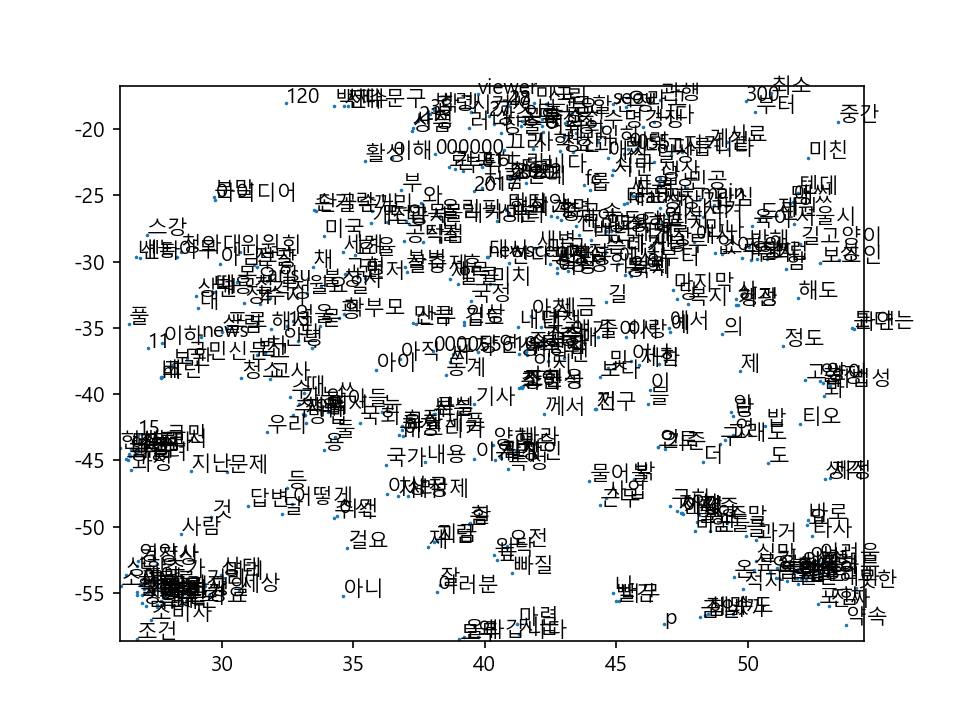

In [44]:
from matplotlib import pyplot as plt
%matplotlib notebook

plt.scatter(wordvec_2d[0:1000,0], wordvec_2d[0:1000,1], s=0.5)

test_words=[]
for i in range(1000):
    test_words.append(index_dict[i])
    
for i, word in enumerate(test_words):
    plt.annotate(word, xy=(wordvec_2d[i, 0], wordvec_2d[i, 1]))
#     plt.rc("font", family="NanumGothic")
